# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

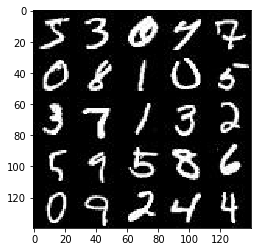

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

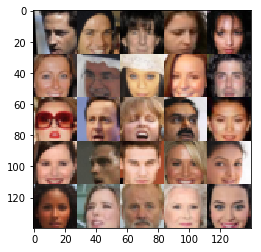

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "D:\\bin\\Miniconda3\\envs\\tensorflow\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "D:\\bin\\Miniconda3\\envs\\tensorflow\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "D:\\bin\\Miniconda3\\envs\\tensorflow\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "D:\\bin\\Miniconda3\\envs\\tensorflow\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "D:\\bin\\Miniconda3\\envs\\tensorflow\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "D:\\bin\\Miniconda3\\en

### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        keep_prob = 0.8
        # Input layer is 28 * 28 * 3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * layer1, layer1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14 * 14 * 64
        
        layer2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7 * 7 * 128
        
        layer3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4 * 4 * 256
        
        flat = tf.reshape(drop3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        layer1 = tf.layers.dense(z, 2 * 2 * 512)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 2 * 2 * 512
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 * 7 * 256
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14 * 14 * 128
        
        layer4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(layer4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 28 * 28 * 64
        
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='same')
        # 28 * 28 * out_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learning_rate_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.3595...
Epoch 1/2... Discriminator Loss: 0.4985... Generator Loss: 3.4926...
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 2.2363...
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 1.7527...
Epoch 1/2... Discriminator Loss: 0.4352... Generator Loss: 4.9640...
Epoch 1/2... Discriminator Loss: 0.3986... Generator Loss: 6.8035...
Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 3.4793...
Epoch 1/2... Discriminator Loss: 3.9548... Generator Loss: 0.1736...
Epoch 1/2... Discriminator Loss: 0.8023... Generator Loss: 1.8691...
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 2.5063...


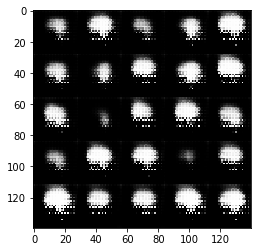

Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 5.4021...
Epoch 1/2... Discriminator Loss: 0.6383... Generator Loss: 3.5247...
Epoch 1/2... Discriminator Loss: 0.5376... Generator Loss: 2.8669...
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.6754...
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 3.6003...
Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 2.8066...
Epoch 1/2... Discriminator Loss: 0.5363... Generator Loss: 4.1746...
Epoch 1/2... Discriminator Loss: 0.7111... Generator Loss: 3.0066...
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 3.8510...
Epoch 1/2... Discriminator Loss: 0.8438... Generator Loss: 2.4525...


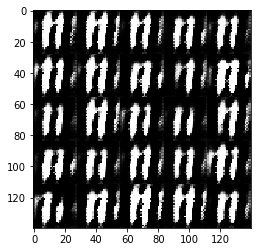

Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 2.4634...
Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 2.3431...
Epoch 1/2... Discriminator Loss: 0.4492... Generator Loss: 3.8934...
Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 2.5773...
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 1.1021...
Epoch 1/2... Discriminator Loss: 0.6577... Generator Loss: 2.9256...
Epoch 1/2... Discriminator Loss: 0.6887... Generator Loss: 2.4518...
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.8996...
Epoch 1/2... Discriminator Loss: 0.7914... Generator Loss: 2.9467...
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.8505...


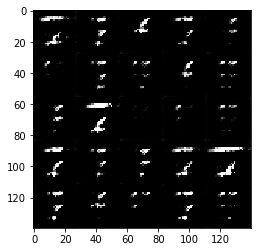

Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 2.7548...
Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 2.3981...
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 3.2512...
Epoch 1/2... Discriminator Loss: 0.5523... Generator Loss: 3.5912...
Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 3.7118...
Epoch 1/2... Discriminator Loss: 0.5296... Generator Loss: 2.6487...
Epoch 1/2... Discriminator Loss: 0.7142... Generator Loss: 2.4214...
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.7526...
Epoch 1/2... Discriminator Loss: 1.0060... Generator Loss: 1.2868...
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 2.0282...


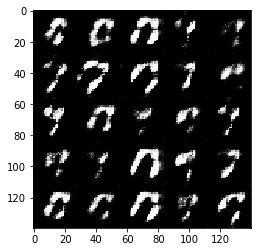

Epoch 1/2... Discriminator Loss: 0.6081... Generator Loss: 2.7363...
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 2.3981...
Epoch 1/2... Discriminator Loss: 0.8005... Generator Loss: 2.5833...
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 2.0177...
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 1.0374...
Epoch 1/2... Discriminator Loss: 0.8641... Generator Loss: 1.9339...
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 1.6364...
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 1.4272...
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 2.1451...
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 2.1946...


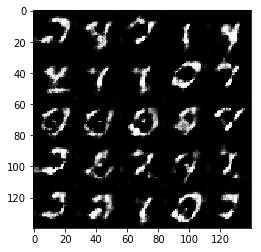

Epoch 1/2... Discriminator Loss: 1.6330... Generator Loss: 3.0279...
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 1.8611...
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 1.6761...
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.7897...
Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 2.1762...
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 1.6685...
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 1.0152...
Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 1.8413...
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 1.3289...
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 2.7932...


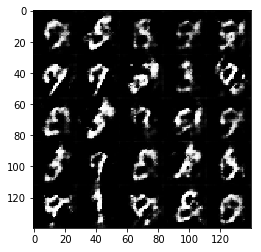

Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 1.1589...
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.4774...
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.5770...
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.6705...
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.6785...
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 1.7725...
Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 1.5188...
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.4441...
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.3792...
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 1.7456...


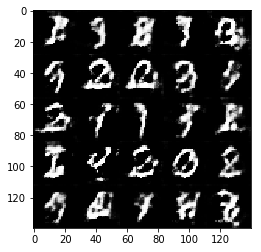

Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.1788...
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 1.2604...
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 1.4139...
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 1.0188...
Epoch 1/2... Discriminator Loss: 1.0062... Generator Loss: 1.9757...
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.7995...
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 1.3103...
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.8244...
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.5044...
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 1.1563...


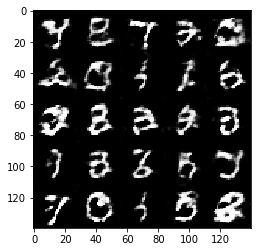

Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 1.9350...
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 1.4039...
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.1863...
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 2.3826...
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.4558...
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 1.8786...
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.9741...
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.5409...
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.5992...
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 1.4966...


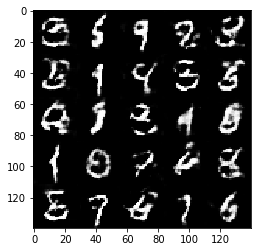

Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 1.4921...
Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.6621...
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 1.9873...
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 1.0225...
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 1.2847...
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 1.6731...
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 1.6264...
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 1.0683...
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 1.5059...
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.6448...


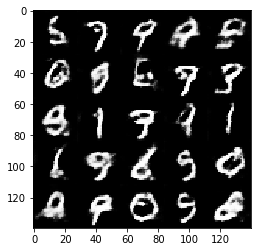

Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.4361...
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.2801...
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 2.1672...
Epoch 2/2... Discriminator Loss: 1.2415... Generator Loss: 1.2831...
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 1.2363...
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.2721...
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 1.4410...
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 1.1682...
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.0382...
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 1.0330...


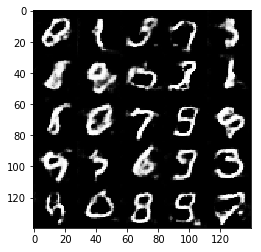

Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.2916...
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 1.6627...
Epoch 2/2... Discriminator Loss: 1.1284... Generator Loss: 1.4413...
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.6723...
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.8059...
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 1.2692...
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.3738...
Epoch 2/2... Discriminator Loss: 1.4179... Generator Loss: 0.6376...
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 1.2943...
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 0.9611...


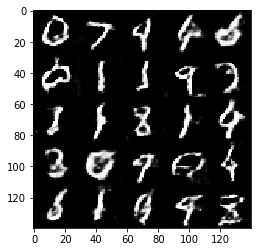

Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.4621...
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 1.4271...
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 1.0704...
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 1.1981...
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 1.3591...
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 1.3788...
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 1.6377...
Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.9544...
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.4915...
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 1.5625...


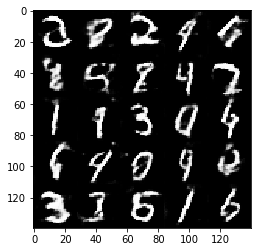

Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.8317...
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.9825...
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 0.9759...
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 1.0520...
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 1.3476...
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 1.1945...
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 1.2640...
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 1.2622...
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 1.9758...
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 1.6758...


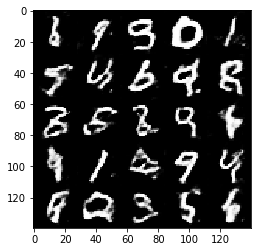

Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 1.0538...
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 1.3348...
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.8215...
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.2341...
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 1.1249...
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 1.3673...
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.4320...
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 1.2013...
Epoch 2/2... Discriminator Loss: 1.7828... Generator Loss: 0.3806...
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.8985...


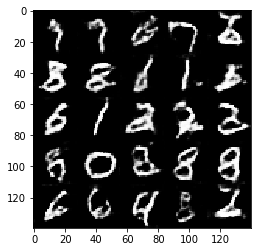

Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 1.0185...
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.3124...
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.9365...
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.4832...
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 1.1174...
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 1.7786...
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 1.4380...
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 1.3915...
Epoch 2/2... Discriminator Loss: 1.2866... Generator Loss: 0.8158...
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 1.6828...


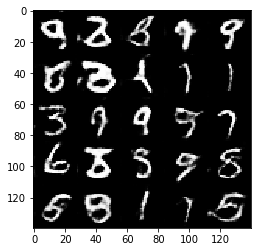

Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.9565...
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 0.9714...
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 1.2231...
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.8719...
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.3519...
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 1.1460...
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.8974...
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.7987...
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.9122...
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7786...


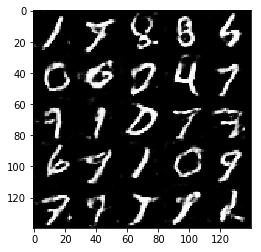

Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.8816...
Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.6818...
Epoch 2/2... Discriminator Loss: 1.4032... Generator Loss: 1.3023...
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 1.2679...
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 1.5629...
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 1.2316...
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 1.4840...
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 1.3227...
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.1398...
Epoch 2/2... Discriminator Loss: 1.6738... Generator Loss: 0.5781...


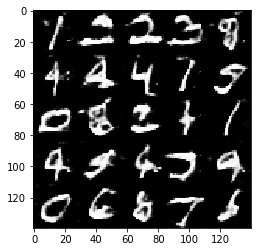

Epoch 2/2... Discriminator Loss: 1.2295... Generator Loss: 0.9235...
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7963...
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 1.1245...
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 1.1393...
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.8009...
Epoch 2/2... Discriminator Loss: 1.4760... Generator Loss: 0.6489...
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.8405...


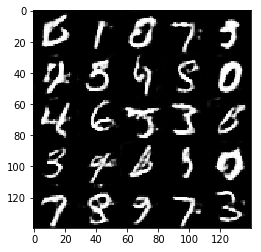

In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.9878...
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 7.6584...
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.8604...
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 10.8240...
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.9348...
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 2.2217...
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 5.7712...
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 4.3797...
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 2.4484...
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 2.5879...


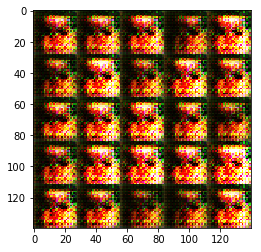

Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 2.1752...
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 5.3008...
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.0187...
Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.8339...
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.5897...
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 3.3091...
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 4.6614...
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 2.8607...
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 2.0820...
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 2.0968...


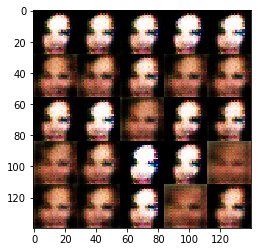

Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 3.4135...
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.4670...
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.2569...
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.4908...
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.4047...
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.9771...
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.1856...
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.9710...
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.2041...
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 2.5793...


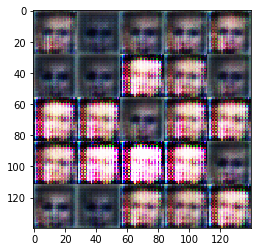

Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6623...
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 2.0077...
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.8392...
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 2.8119...
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 2.0626...
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 1.7000...
Epoch 1/1... Discriminator Loss: 2.6803... Generator Loss: 0.1319...
Epoch 1/1... Discriminator Loss: 1.6576... Generator Loss: 1.8334...
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.8903...
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.9881...


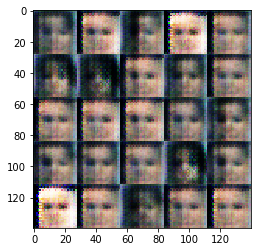

Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.9838...
Epoch 1/1... Discriminator Loss: 2.0910... Generator Loss: 0.5335...
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.1374...
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.9731...
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.6354...
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.5607...
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.1862...
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8541...
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 1.1293...
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 2.5176...


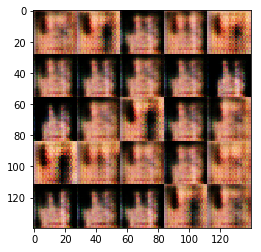

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 3.0416...
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.8829...
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.8506...
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.4047...
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.4826...
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5415...
Epoch 1/1... Discriminator Loss: 1.9664... Generator Loss: 3.4245...
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7680...
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.1730...
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 1.0096...


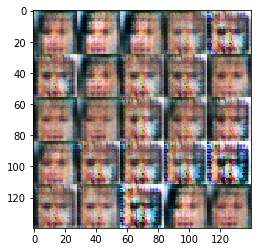

Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.0278...
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.3340...
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.8682...
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.2475...
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.1930...
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.5805...
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.7527...
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.3437...
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.2755...
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.1647...


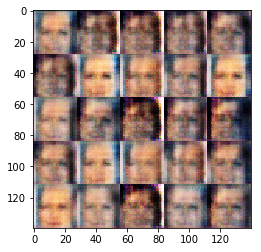

Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.9577...
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 2.2808...
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.6109...
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 1.0287...
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.2339...
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.6387...
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.2578...
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.8890...
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.2780...
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.8307...


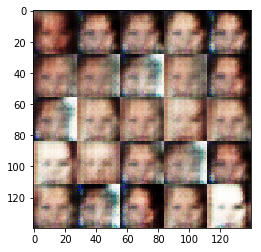

Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 1.4735...
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.9273...
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.2357...
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.6406...
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.3290...
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.2327...
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.9882...
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9723...
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0919...
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.0912...


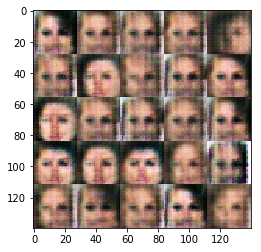

Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.1438...
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.3463...
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.8135...
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.3302...
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.3564...
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.9966...
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.8310...
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.2645...
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.1446...
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.5951...


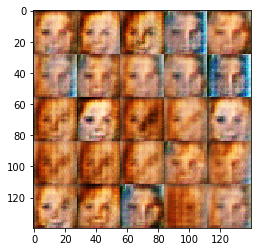

Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.6294...
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.2756...
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.7849...
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.4511...
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.3698...
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.5829...
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.7167...
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.8219...
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.1129...
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.3902...


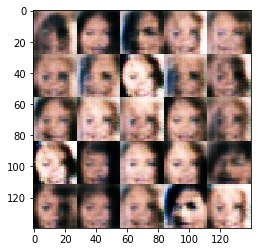

Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.2499...
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.3666...
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.1197...
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.5431...
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 1.0076...
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.8729...
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.9139...
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9559...
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.0111...
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.1459...


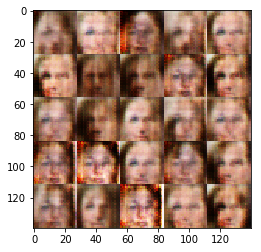

Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.1975...
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7438...
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.4082...
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.0273...
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.5969...
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.4603...
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.5095...
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.7822...
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.8047...
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.6878...


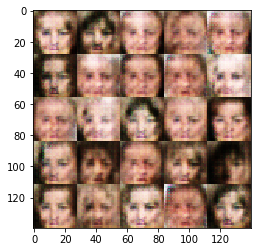

Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8449...
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.1595...
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.6100...
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6960...
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.3739...
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 1.0067...
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9657...
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.0519...
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.9462...
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0590...


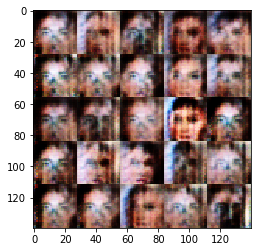

Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.1451...
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9198...
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.3086...
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.3012...
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.2816...
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.2770...
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.2508...
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.1698...
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.6883...
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.4181...


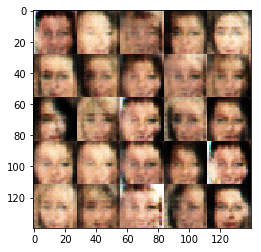

Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7770...
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7880...
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.3841...
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.3778...
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.4504...
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.6144...
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.2481...
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.5820...
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 1.1221...
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.2565...


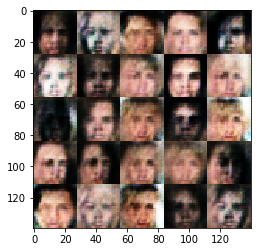

Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.1678...
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.5698...
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9140...
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.1076...
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.0854...
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.2113...
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.2777...
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.0721...
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9482...
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9498...


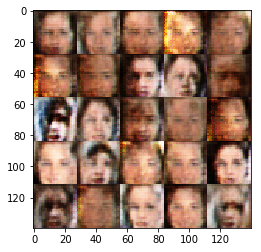

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.8252...
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.7172...
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8745...
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.3522...
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8286...
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.1284...
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.2415...
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.6546...
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.2855...
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.1824...


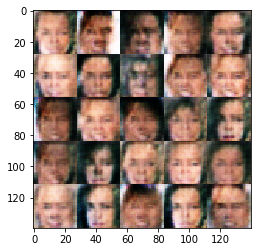

Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 1.3825...
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0722...
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.9818...
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.7642...
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7529...
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 1.1750...
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.4612...
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.3028...
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.0108...
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.5064...


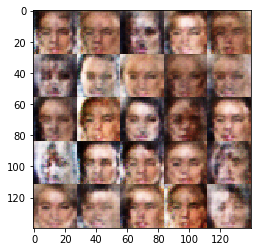

Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.0767...
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.0167...
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.1713...
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8397...
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 1.3516...
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8235...
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.4735...
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.0354...
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.4268...
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.1986...


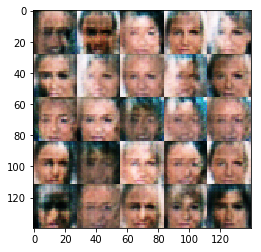

Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 1.7368...
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 1.1215...
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.6217...
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8811...
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.1596...
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.9884...
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.0910...
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.2875...
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 1.0470...
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7477...


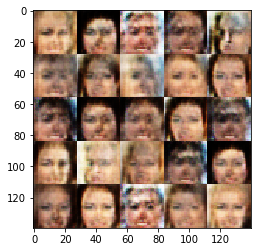

Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.0270...
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.9653...
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.4535...
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.9207...
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.9883...
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.5948...
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.1630...
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.1041...
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9471...
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7538...


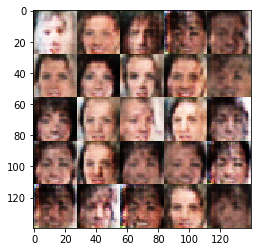

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.3465...
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.3831...
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.6799...
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.3962...
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1085...
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.0735...
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.2134...
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.1477...
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.4263...
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.4461...


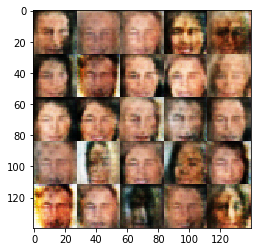

Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.9722...
Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 2.7314...
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.9729...
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.0370...
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8556...
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.3902...
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.0500...
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.0617...
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.6332...
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.3108...


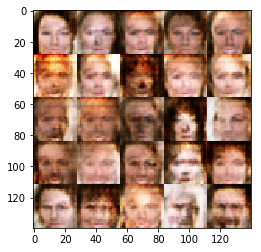

Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.2274...
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.0687...
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.4419...
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 1.2168...
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.0524...
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0310...
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.9309...
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.6855...
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.1902...
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.8723...


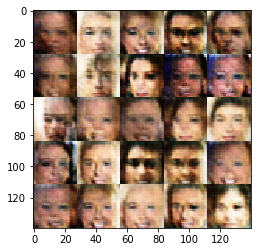

Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.8701...
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.4410...
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.9375...
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.5760...
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.0498...
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.3615...
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.5611...
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.9907...
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.3638...
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.0975...


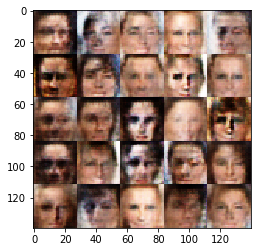

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.8985...
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6681...
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.2716...
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.0670...
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1874...
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6910...
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.0521...
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.0855...
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.3343...
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.2454...


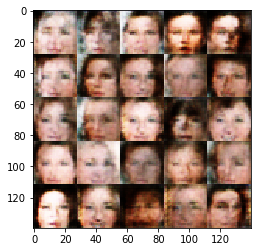

Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.1423...
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.7175...
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.9699...
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.9009...
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.2764...
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.9697...
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.1324...
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.7208...
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.1615...
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.6240...


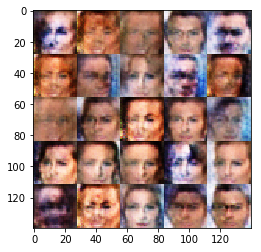

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.1545...
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.9398...
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8789...
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.3071...
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8447...
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.2287...
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.8863...
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.9892...
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8637...
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.2860...


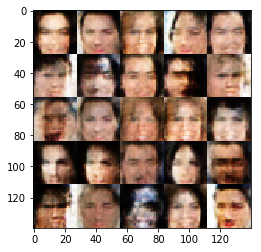

Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.0009...
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.9334...
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.9789...
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.4120...
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.3980...
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7740...
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.3493...
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.2581...
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.2296...
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 1.1638...


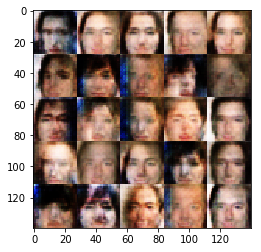

Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.1977...
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.9911...
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8594...
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.1909...
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.2915...
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.9555...
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.0762...
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 1.1473...
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.0091...
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.0513...


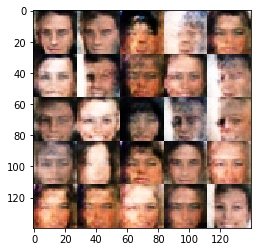

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8498...
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.9842...
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8736...
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 1.0039...
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.1279...
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7483...
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8648...
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 1.1964...
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.0556...
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.1243...


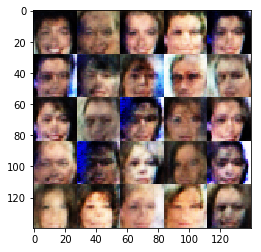

Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.3291...
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.1837...
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.0049...
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.9524...
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.0908...
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.1833...
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.1363...
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8507...
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.8408...
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.0234...


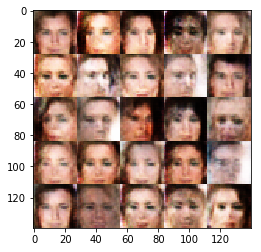

Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7756...
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.2776...
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7284...
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.0038...
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.5378...
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9408...
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.1679...
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5207...
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.1871...
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.3278...


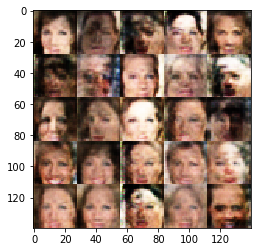

Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.2473...
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 1.0254...
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.9286...
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.0947...
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.8913...
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8783...


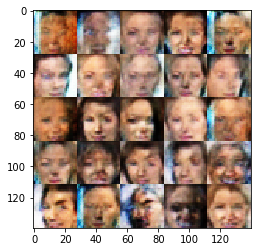

In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。